## Steel price regression - 환율 선 적용

## 변수 정의
### 1. 국내
* weightA: 철 스크랩, 중량A 평균가

### 2. 철스크랩(Scrap Steel) > 한국의 수입가
* importPriceUSA: 미국산 대형 -벌크 (HMS No.1) (달러/톤)
* importPriceJP: 일본 H2 (백엔/톤)

### 3. 철스크랩(Scrap Steel) > 해외가격(Overseas)
* priceCN: 중국 장쑤 내수가 (달러/톤)
* priceJP: 일본 내수가 (백엔/톤)
* priceUSA_TAIWAN : 미국→대만 (컨테이너) (달러/톤)

### 4. 기타 변수
* stock: 국내 제강사 재고
* USD_KR: 달러 환율(해당일 매매기준율)
* JPY_KR: 엔화 환율(해당일 매매기준율)


### Scrap가 부서공식 
* 스크랩가 = weightA*0.7 + importPriceJP*0.2 + importPriceUSA*0.1

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
import matplotlib
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'AppleGothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')
random_seed = 123
pd.set_option('display.max_rows', 500)

In [6]:
def transform_df(_df):
    #날짜형으로 변환
    _df['date'] = pd.to_datetime(_df['date'], format='%Y-%m-%d')
    # 계산을 위해 YEAR-Quarter 컬럼 추가 (값 형태 year.quarter)
    _df['quarter'] = _df['date'].dt.year+ (_df.date.dt.quarter)*0.1
    #Unit 단위 통일 톤/원
    _df['weightA']= _df['weightA'] * 1000
    _df['gosi'] = _df['gosi'] * 1000
    #부서 고유공식(1) 적용된 스크랩가 구하기
    _df['scrap'] = _df['weightA']*0.7 + _df['importPriceJP']*0.2 + _df['importPriceUSA']*0.1
    return _df

In [106]:
# 시계열 모델에서 예측된 각각의 값들
df = pd.read_csv("./data/input_step1_p50.csv")
df = transform_df(df)
dfa=pd.DataFrame()
dfa['weightA_p50']= df['weightA']
df_a = df.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df.groupby(['quarter'])['scrap'].mean().reset_index()


In [107]:
#분기처리를 위한 배열
mr = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
def get_quarter(m):
    if m >= 1 and m <= 3:
        return 1
    elif m >= 4 and m <= 6:
        return 2
    elif m >= 7 and m <= 9:
        return 3
    elif m >= 10 and m <= 12:
        return 4

def get_sgap(row):
    month = row.month #current month
    year = row.year
    if month % 3 == 0 : # 3, 6, 9, 12
        # *9월 = (7, 8월의 스크랩평균가)의 평균가가 전분기 대비 5% +- 상관없이 변동되었을 때.
        #(같은 분기 7월) 고시가 + [(7, 8월의 스크랩평균가) - (전분기, 2분기 스크랩평균가)]
        df_year = df[df['date'].dt.year == year]
        mean1 = df_year[df_year['date'].dt.month == month - 1].scrap.mean()
        mean2 = df_year[df_year['date'].dt.month == month - 2].scrap.mean()
        scrap_mean = (mean1 + mean2) / 2
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        q1 = get_quarter(month) - 1
        if q1 == 0:
            year = year - 1
            q1 = 4
        try:
            previous_q1_mean_scrap = df_b[df_b.quarter == year + q1 * 0.1]['scrap'].values[0]
            result = same_quarter_price+ (scrap_mean - previous_q1_mean_scrap)
            compared_5percent = 0
            if abs(same_quarter_price- result)> same_quarter_price*0.05:
             compared_5percent =  same_quarter_price
            else :
             compared_5percent = result
            return compared_5percent
        except IndexError:
            return -1

    elif month % 3 == 1 : # 1 4 7 10
        # 7월 =전분기의 고시가인 4월 고시가 + [ 4,5,6(2분기) 스크랩 평균가  - 1분기 스크랩평균가 ] ​
        q1 = get_quarter(month) - 1
        previous_q1_mean_scrap = 0
        previous_q2_mean_scrap = 0
        previous_quarter_price = 0
        try:  
            previous_quarter_price  = df[df.quarter == year+0.1*(row.quarter-1)][-1:]['gosi'].values[0]
        except IndexError:
            previous_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        try:  
            if q1 == 0:
                year = year - 1
                q2 = 4
                q1 = 3
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
            elif q1 == 1: # 4 month, 
                print(month)
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']  
                year = year -1
                q2 = 4
            else:
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap'] 
                q2 = q1 - 1
            previous_q2_mean_scrap = df_b[df_b.quarter == (year+q2*0.1)]['scrap']
            print("%d-%d ( %d %d )"%(year, month, q1, q2))
            a = previous_q1_mean_scrap.values[0]
            b = previous_q2_mean_scrap.values[0]
            result = previous_quarter_price + (a - b)
            compared_5percent = 0
            if abs(previous_quarter_price- result)> previous_quarter_price*0.05:
             compared_5percent =  previous_quarter_price
            else:
                compared_5percent = result
            if len(previous_q1_mean_scrap) > 0 and len(previous_q2_mean_scrap) > 0 :
                return compared_5percent
            else: return -1
        except TypeError:  
            return -2
        except Exception:
            return -3
    else : # 2 5 8 11
        # *8월 = 7월의 스크랩평균가가 전분기 대비 5% 변동되었을 경우,
        #(같은 분기의 7월) 고시가 + [( 7월 스크랩 평균가 ) -(전분기, 2분기 스크랩평균가) ]
        df_year = df[df['date'].dt.year == year]
        mean1 =  df_year[df_year['date'].dt.month == month-1 ].scrap.mean()
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        q1 = get_quarter(month)-1        
        if q1 == 0:
            year = year-1
            q1 = 4
        previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
        compared_5percent = 0
        result = 0
        if len(previous_q1_mean_scrap.values) > 0:
            result = same_quarter_price + (mean1 - previous_q1_mean_scrap.values)[0]
        else : 0
        if abs(same_quarter_price- result)> same_quarter_price*0.05:
            compared_5percent =same_quarter_price
        else :
            compared_5percent = result
        
        return compared_5percent
        


In [108]:
dfa['scrap_gap_50'] = df['date'].apply(get_sgap)
#df = df[df['scrap_gap_50']>0] 

2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

In [109]:


df_p90 = pd.read_csv("./data/input_step1_p90.csv") 
df = transform_df(df_p90)
dfa['weightA_p90']= df['weightA']
df_a = df_p90.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df_p90.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['scrap_gap_90'] = df['date'].apply(get_sgap)



2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

In [110]:

df_p10 = pd.read_csv("./data/input_step1_p10.csv")
df = transform_df(df_p10)
dfa['weightA_p10']= df['weightA']
df_a = df_p10.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df_p10.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['scrap_gap_10'] = df_p10['date'].apply(get_sgap)

2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

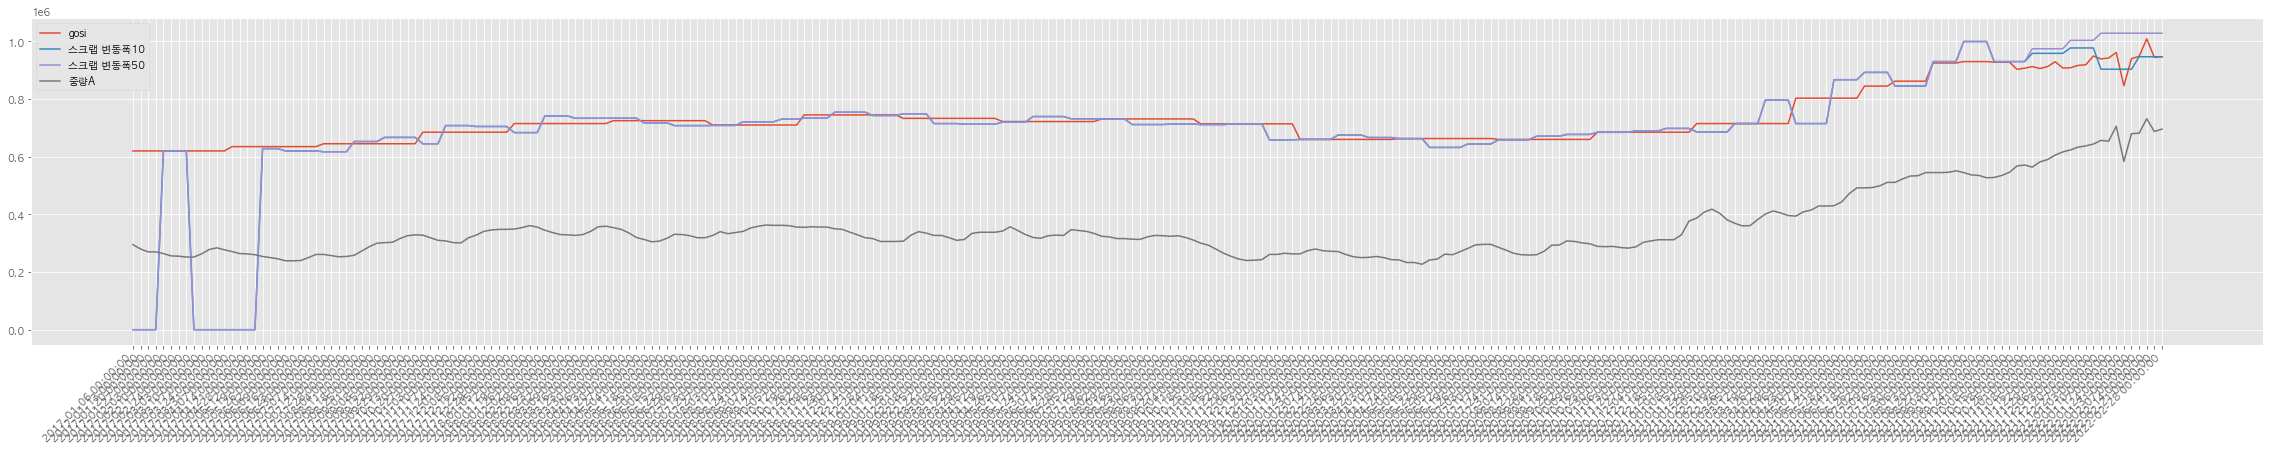

In [66]:


#df['scrap_gap_90'] = df_p90[df_p90['scrap_gap']>0]

import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['gosi'], label = 'gosi')

ay.plot(df.index, dfa['scrap_gap_10'] , label = '스크랩 변동폭10')
ay.plot(df.index, dfa['scrap_gap_50'] , label = '스크랩 변동폭50')
ay.plot(df.index, dfa['scrap_gap_90'] , label = '스크랩 변동폭90')

ay.plot(df.index, df['weightA'], label='중량A')
plt.xticks(xi, df['date'])
plt.legend()
ay.set_xticklabels(df['date'], rotation = 45, ha="right")
plt.show()
fig.savefig('./result_img01/fig2_50.png', dpi = 100)


In [158]:


df_p90 = pd.read_csv("./data/input_step1_p90.csv") 

df = transform_df(df_p90)
dfa['weightA_p90']= df['weightA']
df_a = df_p90.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df_p90.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['scrap_gap_90'] = df['date'].apply(get_sgap)

2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

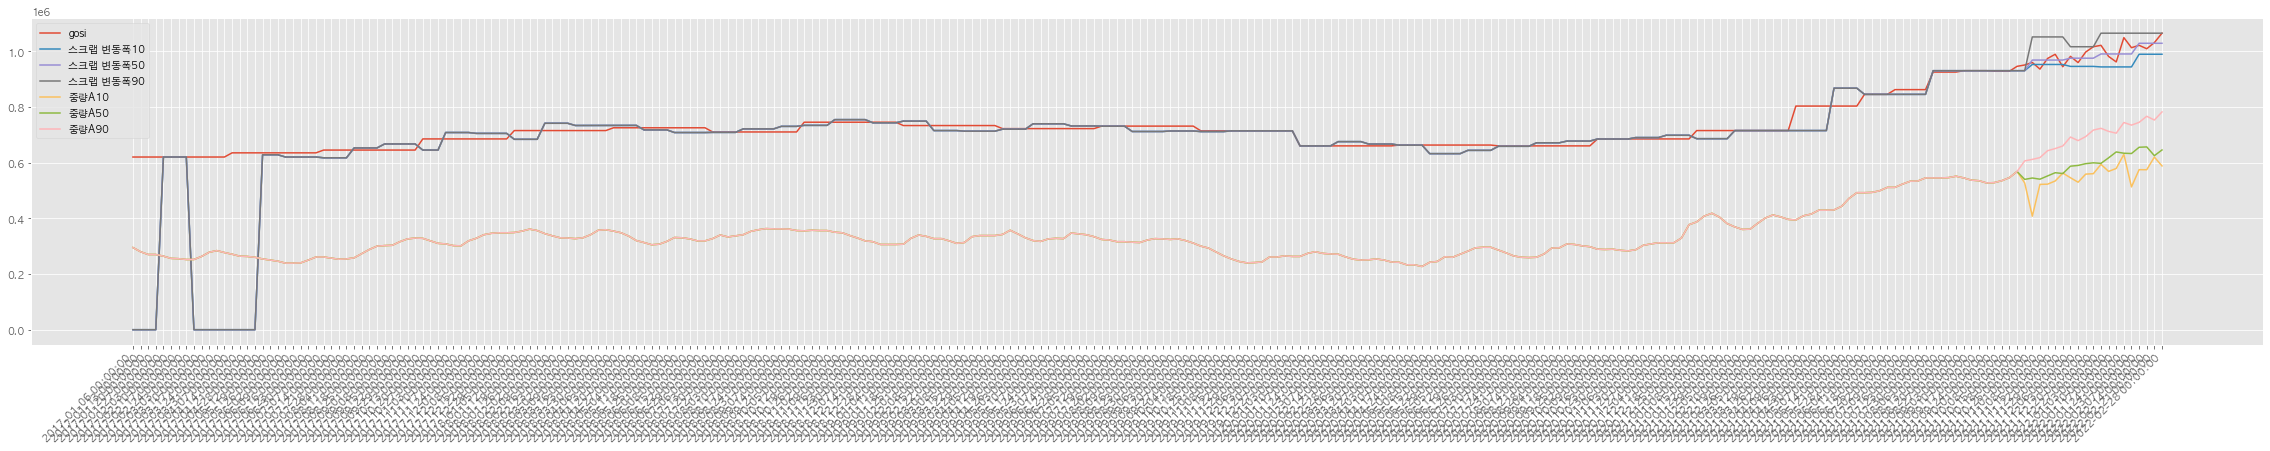

In [160]:


#df['scrap_gap_90'] = df_p90[df_p90['scrap_gap']>0]

import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['gosi'], label = 'gosi')

ay.plot(df.index, dfa['scrap_gap_10'] , label = '스크랩 변동폭10')
ay.plot(df.index, dfa['scrap_gap_50'] , label = '스크랩 변동폭50')
ay.plot(df.index, dfa['scrap_gap_90'] , label = '스크랩 변동폭90')
ay.plot(df.index, dfa['weightA_p10'], label='중량A10')
ay.plot(df.index, dfa['weightA_p50'], label='중량A50')
ay.plot(df.index, dfa['weightA_p90'], label='중량A90')
#ay.plot(df.index, df['weightA'], label='중량A')
plt.xticks(xi, df['date'])
plt.legend()
ay.set_xticklabels(df['date'], rotation = 45, ha="right")
plt.show()
fig.savefig('./result_img01/fig2_50.png', dpi = 100)


In [161]:
dfa.to_csv('data/result_weightA_aws.csv', index=False)

In [152]:
# 시계열 모델에서 예측된 각각의 값들
df_50 = pd.read_csv("./data/step1-model_weightA_p50.csv")
df_50 = transform_df(df_50)
df =df_50
df_a = df_50.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df_50.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['weightA_p50']= df_50['weightA']
dfa['weightA_p50']


0      295000.0000
1      280000.0000
2      270000.0000
3      270000.0000
4      264000.0000
5      256000.0000
6      255000.0000
7      252000.0000
8      252000.0000
9      263000.0000
10     278000.0000
11     284000.0000
12     277000.0000
13     271000.0000
14     264000.0000
15     263000.0000
16     260000.0000
17     254000.0000
18     250000.0000
19     246000.0000
20     239000.0000
21     239000.0000
22     240000.0000
23     250000.0000
24     261000.0000
25     261000.0000
26     257000.0000
27     253000.0000
28     254000.0000
29     258000.0000
30     273000.0000
31     288000.0000
32     300000.0000
33     302000.0000
34     303000.0000
35     316000.0000
36     326000.0000
37     329000.0000
38     328000.0000
39     319000.0000
40     310000.0000
41     308000.0000
42     302000.0000
43     301000.0000
44     319000.0000
45     328000.0000
46     341000.0000
47     346000.0000
48     348000.0000
49     348000.0000
50     349000.0000
51     354000.0000
52     36100

In [147]:
dfa = pd.DataFrame()
dfa['scrap_gap_50'] = df_50['date'].apply(get_sgap)
#df = df[df['scrap_gap_50']>0] 


2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

In [148]:

df_p10 = pd.read_csv("./data/step1-model_weightA_p10.csv")
df = transform_df(df_p10)
dfa['weightA_p10']= df_p10['weightA']
df_a = df_p10.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df_p10.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['scrap_gap_10'] = df['date'].apply(get_sgap)


2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

In [170]:


df_p90_ = pd.read_csv("./data/step1-model_weight_p90.csv") 

df_p90_ = transform_df(df_p90_)
dfa['weightA_p90']= df_p90_['weightA']

df = df_p90_ 
df_a = df.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['scrap_gap_90'] = df['date'].apply(get_sgap)


2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

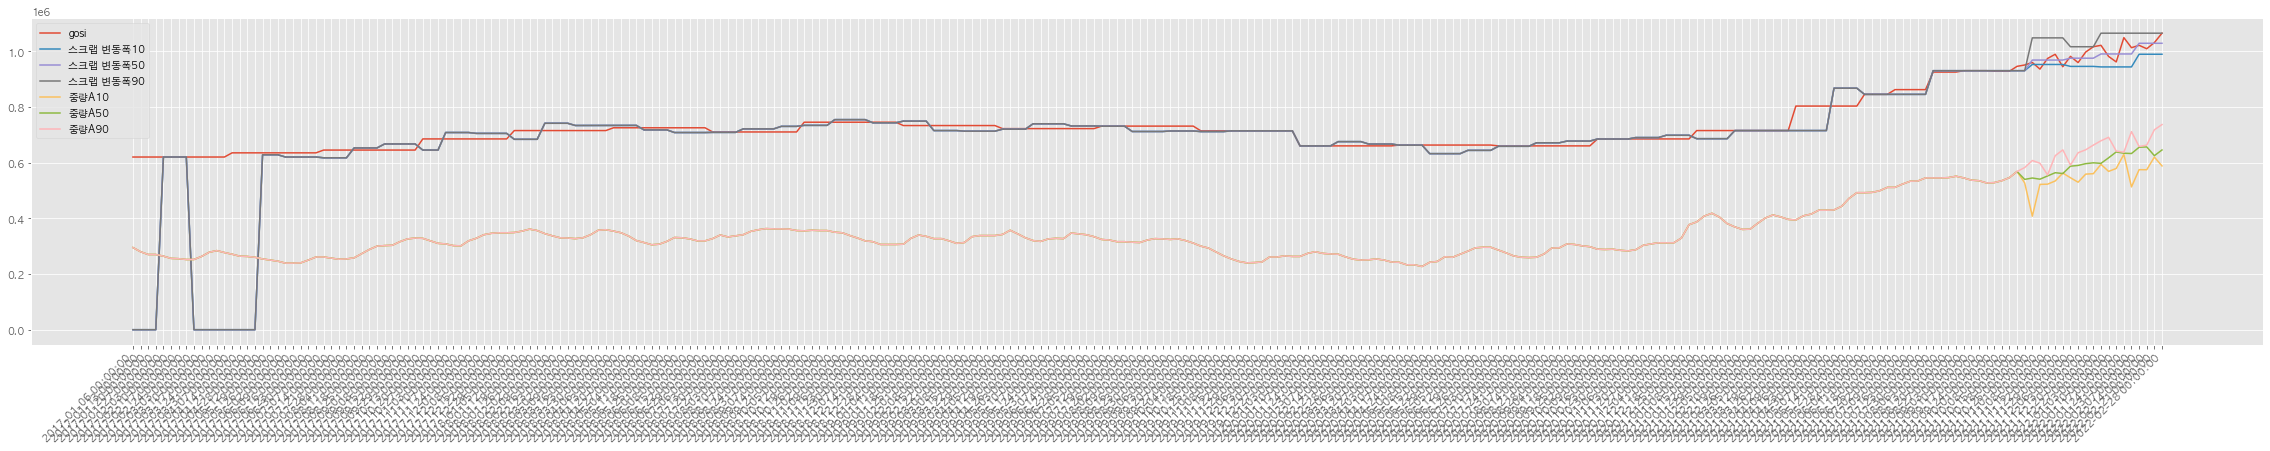

In [171]:
dfa.to_csv('data/result_weightA_linear.csv', index=False)

#df['scrap_gap_90'] = df_p90[df_p90['scrap_gap']>0]

import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['gosi'], label = 'gosi')

ay.plot(df.index, dfa['scrap_gap_10'] , label = '스크랩 변동폭10')
ay.plot(df.index, dfa['scrap_gap_50'] , label = '스크랩 변동폭50')
ay.plot(df.index, dfa['scrap_gap_90'] , label = '스크랩 변동폭90')
ay.plot(df.index, dfa['weightA_p10'], label='중량A10')
ay.plot(df.index, dfa['weightA_p50'], label='중량A50')
ay.plot(df.index, dfa['weightA_p90'], label='중량A90')
plt.xticks(xi, df['date'])
plt.legend()
ay.set_xticklabels(df['date'], rotation = 45, ha="right")
plt.show()
fig.savefig('./result_img01/fig2_p105090.png', dpi = 100)


In [168]:
dfa

,scrap_gap_50,weightA_p10,scrap_gap_10,weightA_p90,scrap_gap_90,weightA_p50
0,-3.000000e+00,295000.0000,-3.000000,295.000000,-3.000000e+00,295000.0000
1,-3.000000e+00,280000.0000,-3.000000,280.000000,-3.000000e+00,280000.0000
2,-3.000000e+00,270000.0000,-3.000000,270.000000,-3.000000e+00,270000.0000
3,-3.000000e+00,270000.0000,-3.000000,270.000000,-3.000000e+00,270000.0000
4,6.200000e+05,264000.0000,620000.000000,264.000000,6.200000e+05,264000.0000
5,6.200000e+05,256000.0000,620000.000000,256.000000,6.200000e+05,256000.0000
6,6.200000e+05,255000.0000,620000.000000,255.000000,6.200000e+05,255000.0000
7,6.200000e+05,252000.0000,620000.000000,252.000000,6.200000e+05,252000.0000
8,-1.000000e+00,252000.0000,-1.000000,252.000000,-1.000000e+00,252000.0000
9,-1.000000e+00,263000.0000,-1.000000,263.000000,-1.000000e+00,263000.0000
